# Enhancing Alzheimer's Disease Diagnosis Using Advanced Deep Learning Techniques Expanded Data Integration, and Explainability


In [1]:
import os
import re
import random
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


import itertools
import torch.optim as optim
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


data_path = '/data/talya/medical_image_processing/Data'

2024-09-14 14:19:52.692598: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 14:19:52.693730: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 14:19:52.716131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 14:19:53.100499: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


True


In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


2024-09-14 14:19:53.807379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-14 14:19:53.808474: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Show images

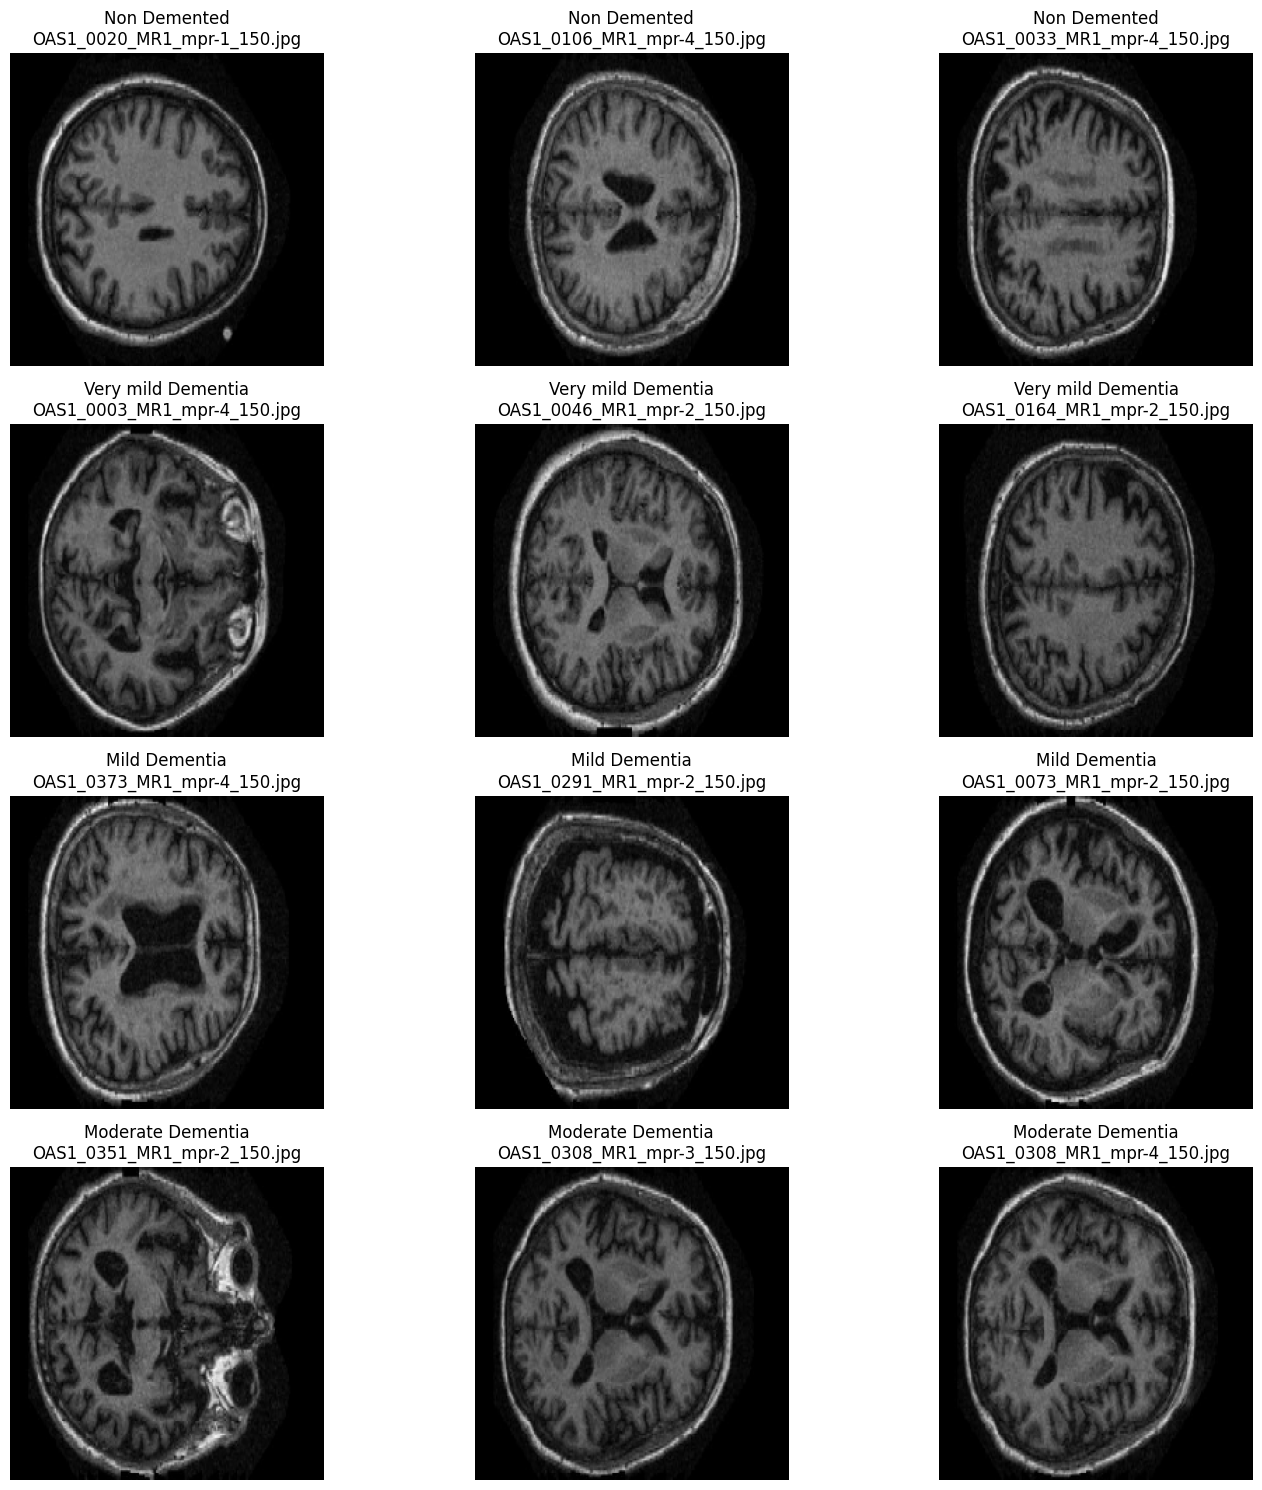

In [13]:


# Define your data path and class directories
classes = ['Non Demented',  'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
img_height, img_width = 224, 224  # Adjust these to your image size
desired_layer = '150'  # Example layer ID for the slice

# Function to extract information from the filename
def get_info_from_filename(filename):
    pattern = re.compile(r'OAS1_(\d+)_MR(\d+)_mpr-(\d+)_(\d+).jpg')
    match = pattern.match(filename)
    if match:
        patient_id = match.group(1)
        mr_id = match.group(2)
        scan_id = match.group(3)
        layer_id = match.group(4)
        return patient_id, mr_id, scan_id, layer_id
    return None, None, None, None

# Function to check if the file is a valid image
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify that it is an image
        return True
    except (IOError, SyntaxError):
        return False

# Function to load and plot images from each class for the same slice (layer)
def plot_images_from_same_slice(data_path, classes, num_images=3, desired_layer='150'):
    fig, axs = plt.subplots(len(classes), num_images, figsize=(15, 15))
    
    for i, category in enumerate(classes):
        category_path = os.path.join(data_path, category)
        images = [img for img in os.listdir(category_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Filter images by the desired layer ID
        images_for_layer = [img for img in images if get_info_from_filename(img)[3] == desired_layer]

        if len(images_for_layer) == 0:
            print(f"No valid images found for layer {desired_layer} in {category}")
            continue

        # Select a random sample of images for the same layer
        selected_images = random.sample(images_for_layer, min(num_images, len(images_for_layer)))

        for j, image_name in enumerate(selected_images):
            image_path = os.path.join(category_path, image_name)
            if is_valid_image(image_path):  # Check if the image is valid
                try:
                    img = load_img(image_path, target_size=(img_height, img_width))
                    img = img_to_array(img) / 255.0  # Normalize the image
                    axs[i, j].imshow(img)
                    axs[i, j].axis('off')
                    axs[i, j].set_title(f'{category}\n{image_name}')
                except Exception as e:
                    print(f"Error loading image {image_name}: {e}")
            else:
                print(f"Skipping invalid image file: {image_name}")
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the images for the same slice (layer)
plot_images_from_same_slice(data_path, classes, num_images=3, desired_layer=desired_layer)


### df with patient info

In [4]:
# Function to extract information from the filename
def get_info_from_filename(filename):
    pattern = re.compile(r'OAS1_(\d+)_MR(\d+)_mpr-(\d+)_(\d+).jpg')
    match = pattern.match(filename)
    
    if match:
        patient_id = match.group(1)
        mr_id = match.group(2)
        scan_id = match.group(3)
        layer_id = match.group(4)
        return patient_id, mr_id, scan_id, layer_id
    else:
        return None


In [5]:
def create_ref_df(dataset_path):
    paths, labels = [], []
    patient_ids, mr_ids, scan_ids, layer_ids = [], [], [], []

    # Iterate through folders in the dataset_path
    for folder in os.listdir(dataset_path):
        if folder == '.DS_Store':
            continue
        
        # Iterate through files in each folder
        for file in os.listdir(os.path.join(dataset_path, folder)):

            # Extract information from the filename using get_info_from_filename function
            patient_id, mr_id, scan_id, layer_id = get_info_from_filename(file)

            # Append information to respective lists
            paths.append(os.path.join(dataset_path, folder, file))
            labels.append(folder)
            patient_ids.append(patient_id)
            mr_ids.append(mr_id)
            scan_ids.append(scan_id)
            layer_ids.append(layer_id)

    # Create a DataFrame from the collected information
    ref_df = pd.DataFrame({
        'path': paths,
        'label': labels,
        'patient_id': patient_ids,
        'mr_id': mr_ids,
        'scan_id': scan_ids,
        'layer_id': layer_ids
    })
    # Convert columns to appropriate data types
    ref_df = ref_df.astype({
        'path': 'string',
        'label': 'string',
        'patient_id': 'int64',
        'mr_id': 'int64',
        'scan_id': 'int64',
        'layer_id': 'int64'
    })

    return ref_df


In [6]:
df = create_ref_df(data_path)
df

path               label  \
0      /data/talya/medical_image_processing/Data/Very...  Very mild Dementia   
1      /data/talya/medical_image_processing/Data/Very...  Very mild Dementia   
2      /data/talya/medical_image_processing/Data/Very...  Very mild Dementia   
3      /data/talya/medical_image_processing/Data/Very...  Very mild Dementia   
4      /data/talya/medical_image_processing/Data/Very...  Very mild Dementia   
...                                                  ...                 ...   
85944  /data/talya/medical_image_processing/Data/Non ...        Non Demented   
85945  /data/talya/medical_image_processing/Data/Non ...        Non Demented   
85946  /data/talya/medical_image_processing/Data/Non ...        Non Demented   
85947  /data/talya/medical_image_processing/Data/Non ...        Non Demented   
85948  /data/talya/medical_image_processing/Data/Non ...        Non Demented   

       patient_id  mr_id  scan_id  layer_id  
0              60      1        2       127  
1             298      1        3       112  
2             226      1        2       122  
3             315      1        2       132  
4             179      1        1       137  
...           ...    ...      ...       ...  
85944         168      1        2       133  
85945         344      1        4       124  
85946         234      1        4       144  
85947          68      1        3       159  
85948         338      1        3       116  

[85949 rows x 6 columns]

In [8]:
# Count distinct patients in the dataset
distinct_patients = df['patient_id'].nunique()
print(f'Distinct patients: {distinct_patients}')
# Count distinct patients in each class
distinct_patients_per_class = df.groupby('label')['patient_id'].nunique()
print(distinct_patients_per_class)


Distinct patients: 345
label
Mild Dementia          21
Non Demented          266
Very mild Dementia     58
Name: patient_id, dtype: int64


In [18]:
df[df['label']=='Moderate Dementia']['patient_id'].unique()

array([308, 351])

- Only 2 patients with Moderate Dementia

In [19]:
# Count the number of images per patient
images_per_patient = df.groupby('patient_id')['path'].count()

# Group by the number of images to get how many patients have each number of images
patients_per_image_count = images_per_patient.value_counts().sort_index()

# Display the summary
print(patients_per_image_count)


122      2
183     45
244    280
366      1
488     19
Name: path, dtype: int64


- Most patients with 244 scans

In [20]:
# Ensure each patient is in only one class
patients_multiple_classes = df.groupby('patient_id')['label'].nunique()

# Find patients that belong to more than one class
patients_in_multiple_classes = patients_multiple_classes[patients_multiple_classes > 1]
print(f'Patients in more than one class: {patients_in_multiple_classes}')


Patients in more than one class: Series([], Name: label, dtype: int64)


In [21]:
import plotly.express as px

# Count the number of images per class
images_per_class = df['label'].value_counts().reset_index()
images_per_class.columns = ['Class', 'Number of Images']

# Create a bar chart with Plotly
fig = px.bar(images_per_class, x='Class', y='Number of Images', text='Number of Images')

# Customize the chart layout
fig.update_traces(textposition='outside')

# Add labels and title
fig.update_layout(
    title='Number of Images per Class',
    xaxis_title='Class',
    yaxis_title='Number of Images',
    yaxis_range=[0, images_per_class['Number of Images'].max() * 1.1],
    template='plotly_white'
)

# Show the chart
fig.show()


## Train - Test Split

In [22]:


# Dictionary to store patient images by category
patient_images = defaultdict(list)

# Loop through the 4 folders (categories)
categories = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

for category in categories:
    category_path = os.path.join(data_path, category)
    
    # Loop through the image files in each category folder
    for img_file in os.listdir(category_path):
        # Extract patient information from the image file name
        info = get_info_from_filename(img_file)
        if info:
            patient_id = info[0]  # Use patient_id to group images
            image_path = os.path.join(category_path, img_file)
            # Append the image path and category to the corresponding patient
            patient_images[patient_id].append((image_path, category))

# Split patients into train, validation, and test sets
patient_ids = list(patient_images.keys())
train_ids, temp_ids = train_test_split(patient_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# Create train, validation, and test splits
train_data = [(img_path, category) for patient_id in train_ids for img_path, category in patient_images[patient_id]]
val_data = [(img_path, category) for patient_id in val_ids for img_path, category in patient_images[patient_id]]
test_data = [(img_path, category) for patient_id in test_ids for img_path, category in patient_images[patient_id]]

# Verify the split sizes
print(f'Train size: {len(train_data)}')
print(f'Validation size: {len(val_data)}')
print(f'Test size: {len(test_data)}')

# Now you can use `train_data`, `val_data`, and `test_data` to load images and labels


Train size: 59902
Validation size: 13176
Test size: 13359


In [23]:
len(patient_ids)

347

In [48]:
import os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Ensure reproducibility
random.seed(42)

# Path to your dataset
data_path = '/data/talya/medical_image_processing/Data'

# Class folders
categories = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

# Dictionary to store patient images by category
patient_images = defaultdict(list)

# Function to extract patient information from the image filename
# Modify this according to your filename format (assumed format: 'patient_001_scan.jpg')
def get_info_from_filename(filename):
    # Assuming the patient ID is in the first two parts of the filename (e.g., 'OAS1_0319_MR1_mpr-2_105.jpg')
    # Adjust this according to your filename structure
    parts = filename.split('_')
    if len(parts) >= 2:
        patient_id = parts[0] + "_" + parts[1]  # Extract patient ID from the first two parts
        return patient_id  # returns just the patient_id
    return None

# Loop through the 4 folders (categories)
for category in categories:
    category_path = os.path.join(data_path, category)
    
    # Loop through the image files in each category folder
    for img_file in os.listdir(category_path):
        # Extract patient information from the image file name
        patient_id = get_info_from_filename(img_file)
        if patient_id:
            image_path = os.path.join(category_path, img_file)
            # Append the image path and category to the corresponding patient
            patient_images[patient_id].append((image_path, category))

# Split patients into train (70%), validation (15%), and test sets (15%)
patient_ids = list(patient_images.keys())

# DEBUG: Print patient IDs to check for consistency
print(f'Total unique patients: {len(patient_ids)}')

# Split the patient IDs into train, validation, and test sets
train_ids, temp_ids = train_test_split(patient_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# DEBUG: Check for patient overlap across sets
print(f'Train patient IDs: {train_ids}')
print(f'Validation patient IDs: {val_ids}')
print(f'Test patient IDs: {test_ids}')

# Create train, validation, and test splits
train_data = [(img_path, category) for patient_id in train_ids for img_path, category in patient_images[patient_id]]
val_data = [(img_path, category) for patient_id in val_ids for img_path, category in patient_images[patient_id]]
test_data = [(img_path, category) for patient_id in test_ids for img_path, category in patient_images[patient_id]]

# Verify that each patient is in only one set
train_patient_ids = {get_info_from_filename(os.path.basename(img_path)) for img_path, _ in train_data}
val_patient_ids = {get_info_from_filename(os.path.basename(img_path)) for img_path, _ in val_data}
test_patient_ids = {get_info_from_filename(os.path.basename(img_path)) for img_path, _ in test_data}

# DEBUG: Check for overlaps between sets
print(f'Overlaps between train and validation: {train_patient_ids.intersection(val_patient_ids)}')
print(f'Overlaps between train and test: {train_patient_ids.intersection(test_patient_ids)}')
print(f'Overlaps between validation and test: {val_patient_ids.intersection(test_patient_ids)}')

assert len(train_patient_ids.intersection(val_patient_ids)) == 0, "Error: Some patients are in both train and validation sets."
assert len(train_patient_ids.intersection(test_patient_ids)) == 0, "Error: Some patients are in both train and test sets."
assert len(val_patient_ids.intersection(test_patient_ids)) == 0, "Error: Some patients are in both validation and test sets."

# Verify the split sizes
print(f'Train size: {len(train_data)}')
print(f'Validation size: {len(val_data)}')
print(f'Test size: {len(test_data)}')

# Now you can use `train_data`, `val_data`, and `test_data` to load images and labels


Total unique patients: 347
Train patient IDs: ['OAS1_0105', 'OAS1_0137', 'OAS1_0327', 'OAS1_0363', 'OAS1_0037', 'OAS1_0247', 'OAS1_0099', 'OAS1_0201', 'OAS1_0322', 'OAS1_0265', 'OAS1_0104', 'OAS1_0325', 'OAS1_0067', 'OAS1_0240', 'OAS1_0234', 'OAS1_0258', 'OAS1_0155', 'OAS1_0090', 'OAS1_0127', 'OAS1_0132', 'OAS1_0365', 'OAS1_0323', 'OAS1_0341', 'OAS1_0303', 'OAS1_0375', 'OAS1_0300', 'OAS1_0295', 'OAS1_0109', 'OAS1_0264', 'OAS1_0310', 'OAS1_0268', 'OAS1_0282', 'OAS1_0345', 'OAS1_0369', 'OAS1_0095', 'OAS1_0202', 'OAS1_0163', 'OAS1_0313', 'OAS1_0116', 'OAS1_0110', 'OAS1_0044', 'OAS1_0259', 'OAS1_0232', 'OAS1_0101', 'OAS1_0204', 'OAS1_0239', 'OAS1_0361', 'OAS1_0015', 'OAS1_0112', 'OAS1_0213', 'OAS1_0284', 'OAS1_0272', 'OAS1_0006', 'OAS1_0382', 'OAS1_0004', 'OAS1_0238', 'OAS1_0302', 'OAS1_0120', 'OAS1_0186', 'OAS1_0082', 'OAS1_0131', 'OAS1_0222', 'OAS1_0229', 'OAS1_0283', 'OAS1_0228', 'OAS1_0151', 'OAS1_0111', 'OAS1_0162', 'OAS1_0097', 'OAS1_0329', 'OAS1_0253', 'OAS1_0210', 'OAS1_0056', 'OAS

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report
import numpy as np
category_mapping = {
    'Non Demented': 0,
    'Very mild Dementia': 1,
    'Mild Dementia': 2,
    'Moderate Dementia': 3
}

# Create datasets and loaders
train_dataset = ImageDataset([img_path for img_path, _ in train_data], [category_mapping[category] for _, category in train_data], transform=transform)
val_dataset = ImageDataset([img_path for img_path, _ in val_data], [category_mapping[category] for _, category in val_data], transform=transform)
test_dataset = ImageDataset([img_path for img_path, _ in test_data], [category_mapping[category] for _, category in test_data], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Parameters
img_height, img_width = 128, 128
batch_size = 16
num_classes = 4
num_epochs = 3
patience = 3  # Early stopping patience
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset (from the previous code)
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Transformations for images (resizing and normalization)
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and loaders
train_dataset = ImageDataset([img_path for img_path, _ in train_data], [category_mapping[category] for _, category in train_data], transform=transform)
val_dataset = ImageDataset([img_path for img_path, _ in val_data], [category_mapping[category] for _, category in val_data], transform=transform)
test_dataset = ImageDataset([img_path for img_path, _ in test_data], [category_mapping[category] for _, category in test_data], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self, hidden_units, dropout_rate, num_classes=4):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm32 = nn.BatchNorm2d(32)
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 16 * 16, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm32(self.conv1(x))))
        x = self.pool(torch.relu(self.batch_norm64(self.conv2(x))))
        x = self.pool(torch.relu(self.batch_norm128(self.conv3(x))))
        x = x.view(-1, 128 * 16 * 16)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
hidden_units = 512
dropout_rate = 0.3
learning_rate = 0.001

model = CNNModel(hidden_units=hidden_units, dropout_rate=dropout_rate, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Early Stopping Variables
best_val_loss = np.inf
early_stop_counter = 0

# Training and validation loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss / len(train_loader):.4f}')
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    
    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        # Save the model if it improves
        torch.save(model.state_dict(), 'best_cnn_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model
model.load_state_dict(torch.load('best_cnn_model.pth'))

# Test the model and generate a classification report
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non Demented', 'Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))


Epoch 1/3
Training Loss: 0.3097
Validation Loss: 1.0771, Validation Accuracy: 72.69%
Epoch 2/3
Training Loss: 0.0653
Validation Loss: 1.7679, Validation Accuracy: 73.23%
Epoch 3/3
Training Loss: 0.0341
Validation Loss: 1.7622, Validation Accuracy: 74.44%
Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.84      0.93      0.88     10248
Very Mild Dementia       0.37      0.34      0.36      1891
     Mild Dementia       0.35      0.08      0.13      1220
 Moderate Dementia       0.00      0.00      0.00         0

          accuracy                           0.77     13359
         macro avg       0.39      0.34      0.34     13359
      weighted avg       0.73      0.77      0.74     13359



/home/mao/miniconda3/envs/talya-archive/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/mao/miniconda3/envs/talya-archive/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/mao/miniconda3/envs/talya-archive/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report
import random
import numpy as np

# Parameters
img_height, img_width = 128, 128
batch_size = 16
num_classes = 4
num_epochs = 3
patience = 3  # Early stopping patience
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset (from the previous code)
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Transformations for images (resizing and normalization)
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Oversample the "Moderate Dementia" class
moderate_demented_train = random.choices(moderate_demented_train, k=500)  # Increase samples to 500

# Manually split moderate_demented patients to ensure some are in the test set
moderate_demented_train, moderate_demented_test = train_test_split(
    category_images['Moderate Dementia'], test_size=0.5, random_state=42  # Use 50% to ensure at least one is in test set
)

# Split the rest of the classes as normal
mild_demented_train, mild_demented_test = train_test_split(
    category_images['Mild Dementia'], test_size=0.2, random_state=42
)
very_mild_demented_train, very_mild_demented_test = train_test_split(
    category_images['Very mild Dementia'], test_size=0.2, random_state=42
)
non_demented_train, non_demented_test = train_test_split(
    category_images['Non Demented'], test_size=0.2, random_state=42
)

# Combine the datasets to ensure all classes are represented in train, val, and test
train_images = moderate_demented_train + mild_demented_train + very_mild_demented_train + non_demented_train
train_labels = (
    [3] * len(moderate_demented_train) +
    [2] * len(mild_demented_train) +
    [1] * len(very_mild_demented_train) +
    [0] * len(non_demented_train)
)

test_images = moderate_demented_test + mild_demented_test + very_mild_demented_test + non_demented_test
test_labels = (
    [3] * len(moderate_demented_test) +
    [2] * len(mild_demented_test) +
    [1] * len(very_mild_demented_test) +
    [0] * len(non_demented_test)
)


# # Combine train data after oversampling
# train_images = moderate_demented_train + mild_demented_train + very_mild_demented_train + non_demented_train
# train_labels = (
#     [3] * len(moderate_demented_train) +  # Label 3 for Moderate Dementia
#     [2] * len(mild_demented_train) +      # Label 2 for Mild Dementia
#     [1] * len(very_mild_demented_train) + # Label 1 for Very Mild Dementia
#     [0] * len(non_demented_train)         # Label 0 for Non Dementia
# )

# Prepare validation and test sets as before
# Create datasets and loaders
train_dataset = ImageDataset(train_images, train_labels, transform=transform)
val_dataset = ImageDataset([img_path for img_path, _ in val_data], [category_mapping[category] for _, category in val_data], transform=transform)
test_dataset = ImageDataset([img_path for img_path, _ in test_data], [category_mapping[category] for _, category in test_data], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self, hidden_units, dropout_rate, num_classes=4):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm32 = nn.BatchNorm2d(32)
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 16 * 16, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm32(self.conv1(x))))
        x = self.pool(torch.relu(self.batch_norm64(self.conv2(x))))
        x = self.pool(torch.relu(self.batch_norm128(self.conv3(x))))
        x = x.view(-1, 128 * 16 * 16)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
hidden_units = 512
dropout_rate = 0.3
learning_rate = 0.001

model = CNNModel(hidden_units=hidden_units, dropout_rate=dropout_rate, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Compute class weights based on the frequency of each class in the training set
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
labels = train_labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Early Stopping Variables
best_val_loss = np.inf
early_stop_counter = 0

# Training and validation loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss / len(train_loader):.4f}')
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    
    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        # Save the model if it improves
        torch.save(model.state_dict(), 'best_cnn_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

#

Epoch 1/3
Training Loss: 0.9571
Validation Loss: 0.3906, Validation Accuracy: 82.95%
Epoch 2/3
Training Loss: 0.4009
Validation Loss: 0.1944, Validation Accuracy: 90.53%
Epoch 3/3
Training Loss: 0.2064
Validation Loss: 0.0842, Validation Accuracy: 96.06%


In [56]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(all_labels, all_preds, labels=[0, 1, 2, 3], target_names=['Non Demented', 'Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']))



Classification Report:
                    precision    recall  f1-score   support

      Non Demented       1.00      0.96      0.98     10248
Very Mild Dementia       0.83      0.98      0.90      1891
     Mild Dementia       0.98      0.99      0.99      1220
 Moderate Dementia       0.00      0.00      0.00         0

         micro avg       0.97      0.97      0.97     13359
         macro avg       0.70      0.73      0.72     13359
      weighted avg       0.97      0.97      0.97     13359



/home/mao/miniconda3/envs/talya-archive/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/mao/miniconda3/envs/talya-archive/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/mao/miniconda3/envs/talya-archive/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/mao/miniconda3/envs/talya-archive/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-

#### Prep ds while making sure each patient will belong only to one set
- Over and under sampling 

In [31]:
import os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
from PIL import Image

# Ensure reproducibility
random.seed(42)

# Path to your dataset
data_path = '/data/talya/medical_image_processing/Data'

# Class folders
categories = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

# Dictionary to store images by category
category_images = defaultdict(list)

# Loop through the folders and load the images into category_images
for category in categories:
    category_folder = os.path.join(data_path, category)
    for img_file in os.listdir(category_folder):
        img_path = os.path.join(category_folder, img_file)
        category_images[category].append(img_path)

# Now we have all images in category_images dictionary, let's split them
# Moderate Dementia split
moderate_demented_train, moderate_demented_test = train_test_split(
    category_images['Moderate Dementia'], test_size=0.2, random_state=42
)

# Mild Dementia split
mild_demented_train, mild_demented_test = train_test_split(
    category_images['Mild Dementia'], test_size=0.2, random_state=42
)

# Very Mild Dementia split
very_mild_demented_train, very_mild_demented_test = train_test_split(
    category_images['Very mild Dementia'], test_size=0.2, random_state=42
)

# Non Demented split
non_demented_train, non_demented_test = train_test_split(
    category_images['Non Demented'], test_size=0.2, random_state=42
)

# Handle class imbalance by oversampling and undersampling
target_samples = 10000

# Oversample smaller classes
moderate_demented_samp = random.choices(moderate_demented_train, k=target_samples)
mild_demented_samp = random.choices(mild_demented_train, k=target_samples)

# Undersample larger classes
very_mild_demented_samp = random.sample(very_mild_demented_train, k=target_samples)
non_demented_samp = random.sample(non_demented_train, k=target_samples)

# Combine the balanced samples for training
train_images = moderate_demented_samp + mild_demented_samp + very_mild_demented_samp + non_demented_samp
train_labels = (
    [3] * len(moderate_demented_samp) +  # Label 3 for Moderate Dementia
    [2] * len(mild_demented_samp) +      # Label 2 for Mild Dementia
    [1] * len(very_mild_demented_samp) + # Label 1 for Very Mild Dementia
    [0] * len(non_demented_samp)         # Label 0 for Non Dementia
)

# Split train set into train and validation
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Combine test data (no oversampling or undersampling for test data)
test_images = moderate_demented_test + mild_demented_test + very_mild_demented_test + non_demented_test
test_labels = (
    [3] * len(moderate_demented_test) +
    [2] * len(mild_demented_test) +
    [1] * len(very_mild_demented_test) +
    [0] * len(non_demented_test)
)

# Verify sizes
print(f'Train size: {len(train_images)}, Validation size: {len(val_images)}, Test size: {len(test_images)}')

# Custom Dataset class to load images and labels
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = ImageDataset(train_images, train_labels, transform=transform)
val_dataset = ImageDataset(val_images, val_labels, transform=transform)
test_dataset = ImageDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model training and testing code goes here...


Train size: 32000, Validation size: 8000, Test size: 17289


In [42]:

# Training and validation loop
def train_cnn(num_epochs, train_loader, val_loader, test_loader):
    # Hyperparameters
    hidden_units = 512
    dropout_rate = 0.3
    learning_rate = 0.001
    num_epochs = 5
    patience = 5
    batch_size = 64
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize the model, optimizer, and loss function
    model = CNNModel(hidden_units=hidden_units, dropout_rate=dropout_rate, num_classes=4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Early stopping variables
    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_model_weights = None
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()
    
        avg_train_loss = train_loss / len(train_loader)
    
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
    
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
    
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
            best_model_weights = model.state_dict()  # Save the best model's weights
        else:
            early_stopping_counter += 1
    
        if early_stopping_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}.')
            break
    
        # Load the best model weights (early stopping)
    model.load_state_dict(best_model_weights)
    
    # Test the model and generate a classification report
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Generate and print the classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Non Demented', 'Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']))


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report

# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self, hidden_units, dropout_rate, num_classes=4):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm32 = nn.BatchNorm2d(32)
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 16 * 16, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm32(self.conv1(x))))
        x = self.pool(torch.relu(self.batch_norm64(self.conv2(x))))
        x = self.pool(torch.relu(self.batch_norm128(self.conv3(x))))
        x = x.view(-1, 128 * 16 * 16)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



train_cnn(num_epochs, train_loader, val_loader, test_loader)


Epoch [1/5], Train Loss: 0.7594, Val Loss: 0.3877, Val Accuracy: 83.34%
Epoch [2/5], Train Loss: 0.2254, Val Loss: 0.1132, Val Accuracy: 95.95%
Epoch [3/5], Train Loss: 0.1396, Val Loss: 0.0947, Val Accuracy: 96.70%
Epoch [4/5], Train Loss: 0.0925, Val Loss: 0.0373, Val Accuracy: 98.66%
Epoch [5/5], Train Loss: 0.0664, Val Loss: 0.0359, Val Accuracy: 98.85%
Classification Report:
                    precision    recall  f1-score   support

      Non Demented       1.00      0.96      0.98     13445
Very Mild Dementia       0.90      0.99      0.95      2745
     Mild Dementia       0.85      1.00      0.92      1001
 Moderate Dementia       0.88      1.00      0.94        98

          accuracy                           0.97     17289
         macro avg       0.91      0.99      0.95     17289
      weighted avg       0.97      0.97      0.97     17289



- Over smaple only to  Moderate Dementia 

In [43]:
import os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
from PIL import Image

# Ensure reproducibility
random.seed(42)

# Path to your dataset
data_path = '/data/talya/medical_image_processing/Data'

# Class folders
categories = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

# Dictionary to store images by category
category_images = defaultdict(list)

# Loop through the folders and load the images into category_images
for category in categories:
    category_folder = os.path.join(data_path, category)
    for img_file in os.listdir(category_folder):
        img_path = os.path.join(category_folder, img_file)
        category_images[category].append(img_path)

# Now we have all images in category_images dictionary, let's split them
# Moderate Dementia split
moderate_demented_train, moderate_demented_test = train_test_split(
    category_images['Moderate Dementia'], test_size=0.2, random_state=42
)

# Mild Dementia split
mild_demented_train, mild_demented_test = train_test_split(
    category_images['Mild Dementia'], test_size=0.2, random_state=42
)

# Very Mild Dementia split
very_mild_demented_train, very_mild_demented_test = train_test_split(
    category_images['Very mild Dementia'], test_size=0.2, random_state=42
)

# Non Demented split
non_demented_train, non_demented_test = train_test_split(
    category_images['Non Demented'], test_size=0.2, random_state=42
)

# Handle oversampling for the Moderate Dementia class
target_samples = 10000  # Target number of samples for Moderate Dementia

# Oversample Moderate Dementia
moderate_demented_train_samp = random.choices(moderate_demented_train, k=target_samples)

# Use the original sizes for other classes
# No oversampling or undersampling for Non Demented, Very Mild Dementia, and Mild Dementia
train_images = moderate_demented_train_samp + mild_demented_train + very_mild_demented_train + non_demented_train
train_labels = (
    [3] * len(moderate_demented_train_samp) +  # Label 3 for oversampled Moderate Dementia
    [2] * len(mild_demented_train) +           # Label 2 for Mild Dementia
    [1] * len(very_mild_demented_train) +      # Label 1 for Very Mild Dementia
    [0] * len(non_demented_train)              # Label 0 for Non Dementia
)

# Split train set into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Combine test data (no oversampling or undersampling for test data)
test_images = moderate_demented_test + mild_demented_test + very_mild_demented_test + non_demented_test
test_labels = (
    [3] * len(moderate_demented_test) +
    [2] * len(mild_demented_test) +
    [1] * len(very_mild_demented_test) +
    [0] * len(non_demented_test)
)

# Verify sizes
print(f'Train size: {len(train_images)}, Validation size: {len(val_images)}, Test size: {len(test_images)}')

# Custom Dataset class to load images and labels
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = ImageDataset(train_images, train_labels, transform=transform)
val_dataset = ImageDataset(val_images, val_labels, transform=transform)
test_dataset = ImageDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model training and testing code goes here...


Train size: 63006, Validation size: 15752, Test size: 17289


In [44]:
train_cnn(num_epochs, train_loader, val_loader, test_loader)

Epoch [1/5], Train Loss: 0.3870, Val Loss: 0.1788, Val Accuracy: 92.60%
Epoch [2/5], Train Loss: 0.1044, Val Loss: 0.0648, Val Accuracy: 97.64%
Epoch [3/5], Train Loss: 0.0542, Val Loss: 0.0142, Val Accuracy: 99.54%
Epoch [4/5], Train Loss: 0.0339, Val Loss: 0.0236, Val Accuracy: 99.13%
Epoch [5/5], Train Loss: 0.0240, Val Loss: 0.0034, Val Accuracy: 99.89%
Classification Report:
                    precision    recall  f1-score   support

      Non Demented       1.00      1.00      1.00     13445
Very Mild Dementia       1.00      1.00      1.00      2745
     Mild Dementia       1.00      0.99      1.00      1001
 Moderate Dementia       1.00      1.00      1.00        98

          accuracy                           1.00     17289
         macro avg       1.00      1.00      1.00     17289
      weighted avg       1.00      1.00      1.00     17289



### CNN

### Grid Search

In [30]:
class CNNModel(nn.Module):
    def __init__(self, hidden_units, dropout_rate, num_classes=4):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm32 = nn.BatchNorm2d(32)
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 16 * 16, hidden_units)  # Change hidden_units dynamically
        self.fc2 = nn.Linear(hidden_units, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)  # Change dropout_rate dynamically

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm32(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm64(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm128(self.conv3(x))))
        x = x.view(-1, 128 * 16 * 16)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No softmax here, handled by CrossEntropyLoss
        return x


In [34]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False  # Continue training
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered after {self.patience} epochs.")
                return True  # Stop training
        return False



In [35]:
hidden_units_values = [128, 256, 512]
dropout_rate_values = [0.3, 0.5, 0.7]
learning_rate_values = [0.001, 0.01, 0.1]
batch_size_values = [16, 32, 64]

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(hidden_units_values, dropout_rate_values, learning_rate_values, batch_size_values))


In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Parameters for cross-validation
k_folds = 5

# Initialize KFold
kf = KFold(n_splits=k_folds, shuffle=True)

# Early stopping instance
early_stopping = EarlyStopping(patience=3)

# Cross-validation loop
for hidden_units, dropout_rate, learning_rate, batch_size in param_combinations:
    print(f"Training with hidden_units={hidden_units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}")
    
    fold_val_acc = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_image_paths)):
        print(f'Fold {fold+1}/{k_folds}')
        
        # Create train/validation datasets for the current fold
        train_subset = torch.utils.data.Subset(train_dataset, train_idx)
        val_subset = torch.utils.data.Subset(train_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
        
        # Initialize the model
        model = CNNModel(hidden_units=hidden_units, dropout_rate=dropout_rate).to(device)

        # Define optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Training loop with early stopping
        best_val_loss = float('inf')
        for epoch in range(num_epochs):
            # Train the model
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # Validate the model
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader)
            val_acc = 100 * correct / total
            print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            # Early stopping check
            if early_stopping(val_loss):
                break
        
        # Record validation accuracy for the fold
        fold_val_acc.append(val_acc)
    
    # Calculate average validation accuracy across folds
    avg_val_acc = np.mean(fold_val_acc)
    print(f"Average Validation Accuracy for this hyperparameter set: {avg_val_acc:.2f}%")
    
    # Track best parameters based on cross-validation
    if avg_val_acc > best_acc:
        best_acc = avg_val_acc
        best_params = (hidden_units, dropout_rate, learning_rate, batch_size)

print(f"Best validation accuracy: {best_acc:.2f}% with params {best_params}")


### Training with best params:
- Best params are hidden_units=512, dropout_rate=0.3, learning_rate=0.001, batch_size=16

In [37]:


# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self, hidden_units, dropout_rate, num_classes=4):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm32 = nn.BatchNorm2d(32)
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 16 * 16, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm32(self.conv1(x))))
        x = self.pool(torch.relu(self.batch_norm64(self.conv2(x))))
        x = self.pool(torch.relu(self.batch_norm128(self.conv3(x))))
        x = x.view(-1, 128 * 16 * 16)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Assuming your train, validation, and test datasets are already defined

# Hyperparameters
hidden_units = 512
dropout_rate = 0.3
learning_rate = 0.001
batch_size = 16
num_epochs = 30
num_classes = 4  # Example number of classes

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create data loaders (assuming you have ImageDataset defined earlier)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Initialize the model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(hidden_units=hidden_units, dropout_rate=dropout_rate, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Validation loop (optional for monitoring validation accuracy)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(f'Validation Accuracy: {val_acc:.2f}%')

# Test the model and generate a classification report
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Non Demented', 'Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']))


Epoch [1/30], Loss: 0.3467
Epoch [2/30], Loss: 0.0720
Epoch [3/30], Loss: 0.0330
Epoch [4/30], Loss: 0.0236
Epoch [5/30], Loss: 0.0166
Epoch [6/30], Loss: 0.0128
Epoch [7/30], Loss: 0.0116
Epoch [8/30], Loss: 0.0076
Epoch [9/30], Loss: 0.0084
Epoch [10/30], Loss: 0.0077
Epoch [11/30], Loss: 0.0073
Epoch [12/30], Loss: 0.0059
Epoch [13/30], Loss: 0.0089
Epoch [14/30], Loss: 0.0054
Epoch [15/30], Loss: 0.0052
Epoch [16/30], Loss: 0.0052
Epoch [17/30], Loss: 0.0057
Epoch [18/30], Loss: 0.0042
Epoch [19/30], Loss: 0.0045
Epoch [20/30], Loss: 0.0049
Epoch [21/30], Loss: 0.0053
Epoch [22/30], Loss: 0.0047
Epoch [23/30], Loss: 0.0043
Epoch [24/30], Loss: 0.0030
Epoch [25/30], Loss: 0.0041
Epoch [26/30], Loss: 0.0046
Epoch [27/30], Loss: 0.0034
Epoch [28/30], Loss: 0.0057
Epoch [29/30], Loss: 0.0042
Epoch [30/30], Loss: 0.0015
Validation Accuracy: 72.31%
Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.82      0.93      0.87     102

/home/mao/miniconda3/envs/talya-archive/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/mao/miniconda3/envs/talya-archive/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/mao/miniconda3/envs/talya-archive/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models, transforms
from sklearn.metrics import classification_report
import numpy as np

# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 50  # We'll stop early if performance doesn't improve
patience = 5  # Early stopping patience
num_classes = 4  # Example number of classes
k_folds = 5  # Number of cross-validation folds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Adjust to (224, 224) for ResNet and DenseNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Early stopping instance
early_stopping = EarlyStopping(patience=patience)

# Function to train and validate a model
def train_and_validate(model, criterion, optimizer, train_loader, val_loader):
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Early stopping check
        if early_stopping(val_loss):
            break

# K-Fold Cross Validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Training loop with k-fold cross-validation
def cross_validate_model(model_class, train_dataset, test_loader):
    fold_val_acc = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f'Fold {fold+1}/{k_folds}')
        
        # Subset training and validation data for current fold
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        # Initialize the model
        model = model_class(pretrained=True).to(device)
        
        # Modify final layer depending on model architecture
        if isinstance(model, models.ResNet) or isinstance(model, models.Inception3):
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif isinstance(model, models.DenseNet):
            model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        
        model = model.to(device)
        
        # Define optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        
        # Train and validate the model
        train_and_validate(model, criterion, optimizer, train_loader, val_loader)

        # Evaluate on test set (classification report)
        evaluate_model_on_test_set(model, test_loader)
        
        # Store fold accuracy
        fold_val_acc.append(val_acc)

    print(f'Average Validation Accuracy across folds: {np.mean(fold_val_acc):.2f}%')


# Function to evaluate the model on the test set
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Non Demented', 'Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']))

# Cross-validation on CNN, ResNet, DenseNet, and Inception-v3 models





print("\nCross-validation on Inception-v3:")
cross_validate_model(models.inception_v3, train_dataset, test_loader)

# You can add CNN in a similar way by defining a CNN model class and using cross_validate_model function with it.


### Train Resnet
- ResNet is a popular CNN architecture that uses residual blocks to improve training for deeper networks

In [ ]:
print("Cross-validation on ResNet:")
cross_validate_model(models.resnet50, train_dataset, test_loader)

### DenseNet 
- DenseNet connects each layer to every other layer, which helps to improve the flow of gradients during backpropagation

In [ ]:
print("\nCross-validation on DenseNet:")
cross_validate_model(models.densenet121, train_dataset, test_loader)

In [ ]:

### 2. DenseNet ###
# Load a pre-trained DenseNet and modify the final layer
densenet = models.densenet121(pretrained=True)
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)  # Modify the final classifier
densenet = densenet.to(device)

# Define loss and optimizer
optimizer = optim.Adam(densenet.parameters(), lr=learning_rate)

# Train and evaluate DenseNet
print("Training DenseNet...")
train_model(densenet, criterion, optimizer, num_epochs)
print("Testing DenseNet...")
test_model(densenet)


### Inception-v3
- Inception-v3 is a deep convolutional neural network known for its use of inception modules to increase the network's width and depth.

In [ ]:
print("\nCross-validation on Inception-v3:")
cross_validate_model(models.inception_v3, train_dataset, test_loader)

In [ ]:

### 3. Inception-v3 ###
# Load a pre-trained Inception-v3 and modify the final layer
inception = models.inception_v3(pretrained=True)
inception.fc = nn.Linear(inception.fc.in_features, num_classes)  # Modify the final fully connected layer
inception = inception.to(device)

# Define loss and optimizer
optimizer = optim.Adam(inception.parameters(), lr=learning_rate)

# Train and evaluate Inception-v3
print("Training Inception-v3...")
train_model(inception, criterion, optimizer, num_epochs)
print("Testing Inception-v3...")
test_model(inception)


In [ ]:
# Example for your CNN
print("\nCross-validation on CNN:")
cross_validate_model(CNNModel, train_dataset, test_loader)
